In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# マルコフ連鎖
* 確率過程$(x^{0}, x^{1}, \cdots)$が全ての$i, j \in \chi$と$t \geq 0$に対して  
$$
&P(x^{(t+1)} = j | x{(0) = i_0, x{1} = i_1, \cdots, x{(t-1)} = i_{t-1}, x^{(t)} = i)  
\\
&= P(x^{(t+1)} = j | x^{(t)} = i)
$$

In [15]:
np.random.multinomial(1, [0.1, 0.3, 0.6])

array([0, 1, 0])

In [ ]:
transition_mat = np.array([[1/2, 1/3, 1/6], [3/4, 0, 1/4], [0, 1, 0]])
states = [0, 1, 2]
x_0 = np.random.multinomial(1, transition_mat[0])
T = 100
x = [x_0]
for t in range(1, T + 1):
    transition_mat[x[t-1] + 1]

# メトロポリスヘイスティングス
1. 酔歩連鎖
2. ランジェヴァン連鎖
3. 独立連鎖
4. ARMHアルゴリズム(acceptance-rejection Metropolis-Hastings algorithm)

* 基本のアルゴリズム
0. x^{(0)}を初期化する
1. $t=0, 1, \cdots$について  
1.$y \sim q(y|x^{(t)})$
2. $u \sim Uniform(0, 1)$として  
$$
x^{(t+1)} = 
\begin{cases}
y　\quad if \quad u \leq \alpha(x^{(t)}, y)
\\
x^{(t)} \quad else
\end{cases}
$$
とする。ただし、
$$
\alpha(x, y) = \min{(1, \frac{\pi(y)/q(x|y)}{\pi(x)/q(y|x)}}
$$

/Users/kthstkhs/.pyenv/versions/3.7.3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


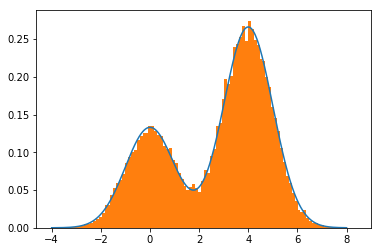

In [17]:
x_th = np.linspace(-4, 8, 1000)
y_th = 1 / (3*np.sqrt(2*np.pi)) * np.exp(-x_th**2/2) + 2 / (3*np.sqrt(2*np.pi)) * np.exp(-(x_th-4)**2/2) 
ratio = [1, 2]
n_sample = 10000
x_1 = np.random.normal(0, 1, n_sample)
x_2 = np.random.normal(4, 1, n_sample*2)
x = np.hstack([x_1, x_2])
plt.plot(x_th, y_th)
plt.hist(x, normed=True, bins=100)
plt.show()

この目標分布からのサンプルを得るため、
$$
    y = x + \epsilon
$$
$$
    \epsilon \sim U(-\sigma, \sigma)
$$
である酔歩連鎖を考える。この時のパラメータ$\sigma$はステップサイズと呼ばれるパラメータであり、採択確率と状態空間内の遷移時間に影響する。また、$\epsilon$の分布としては正規分布、一様分布も用いられる。

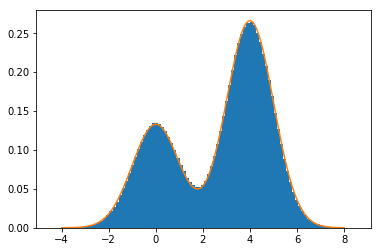

Acceptance ration: 0.9652031


In [26]:
def calc_target_dist(x):
    return 1/ 3 * (1 / np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2) + 2 / 3 * (1 / np.sqrt(2 * np.pi)) * np.exp(-(x - 4)**2 / 2)

x_init = 0
step_size = 0.2
iter_num = 10000000
sample_list = []
sample_list.append(x_init)
x_previous = x_init
accept_num = 0
for i in range(0, iter_num):
    y = x_previous + np.random.uniform(-step_size, step_size)
    u = np.random.uniform(0, 1)
    
    alpha = min(1, calc_target_dist(y) / calc_target_dist(x_previous))
    if u <= alpha:
        sample_list.append(y)
        x_previous = y
        accept_num += 1
    else:
        sample_list.append(x_previous)
        x_previous = x_previous
plt.hist(sample_list, density=True, bins=100)
plt.plot(x_th, y_th)
plt.show()
print("Acceptance ration: {}".format(accept_num / iter_num))

* 上のメモ  
step_sizeを最初の1から0.2に下げた。iter_numをそのままにすると事後分布を近似しきれない。そのためiter_numを2ケタあげたところ、採択確率0.965でかなりいいサンプルが得られた。

* トレースプロット

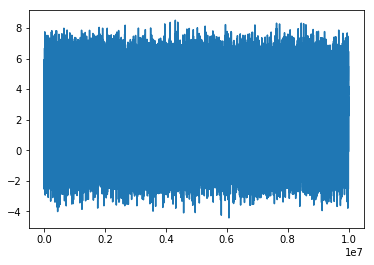

In [29]:
plt.plot(sample_list)
plt.show()

* ランジェヴァン連鎖は  
$$
y = x + \frac{\sigma^{2}}{2}\frac{\partial{log\pi(x)}}{\partial x} + \epsilon
\\
\epsilon \sim N(0, \sigma^2I)
$$  
で定義される。現在の状態が目標のモードに近ければ微分項が0に近くなり酔歩連鎖に近い挙動をする。一方、離れている時には酔歩連鎖よりもモードに近い領域に候補を発生しやすくなる。

* 独立連鎖は現在状態に依存せずに候補を発生させる。この時、採択確率は  
$$
\alpha(x, y) = \min{(1, \frac{\pi(y)/q(y)}{\pi(x)/q(x)})}
$$
とする。実際には提案分布として、$\pi(x)$のモードを平均、${{-\partial  log{\pi(x)} / \partial x \partial x^{'}}}^{-1}$を共分散行列とする多変量t分布がよく用いられる。

## ARMHアルゴリズム(acceptance-rejection Metropolis-Hastings algorithm)
* 棄却法の考えにより、独立連鎖よりも提案分布の近似を改善し、採択確率を高める
* 棄却法のように$\pi(x) \leq Cq(x)$が必ず成り立つ必要はない
* $\pi(x)$のモード$\pi-*$が求められれば$C = \pi(x^*) / q(x^*)$を設定するのがよい

## MHアルゴリズムの組み合わせ
* 複数のMHアルゴリズムを組み合わせて効率的なサンプリングを簡単に実現できる
* 混合推移核は確率$w$で1番目のMHアルゴリズムを使うことにすれば、  
$$
T(x, y) = wT_1(x, y) + (1 - w)T_2(x, y)
$$  
と表現できる。
* 混合型の他に循環型も知られている
* 循環型遷移核を応用した方法が以下のギブスサンプリングとなる

# ギブスサンプリング
* サンプル$x$をk個のブロックに分割して各ブロックをそれ以外のサンプルブロックの条件付き確率分布からサンプリングする手法である. この分布を完全条件付き分布と呼ぶ
$$
    x_i \sim \pi(x_1, \cdots, x_{i-1}, x_{i+1}, \cdots, x_k)
$$

1. initialize $x$ with random values
2. for $t \leftarrow 1: k$ do  
    1. $x_1^{(t+1)} \sim \pi(x_1|x_2^{(t)}, \cdots, x_k^{(t)})$
    2. $x_2^{(t+1)} \sim \pi(x_2|x_1^{(t+1)}, \cdots, x_k^{(t)})$  
    $\vdots$  
    k. $x_k^{(t+1)} \sim \pi(x_k|x_1^{(t+1)}, \cdots, x_{k-1}^{(t+1)})$

* ギブスサンプリングでは$\pi(x)$を普遍分布としてもつが、詳細釣り合い条件は必ずしも満たされないことに注意しなけらばならない
* ギブスサンプリングで一部の完全条件付き分布からのサンプリングが行えない時にはそれを適切なMHアルゴリズムで置き換えてもよい. この組み合わせ法はMetropolis within Gibbs algorithmとして知られている.

## 多重ブロックMHアルゴリズム
* いくつかの式変形により、ギブスサンプリングが多重ブロックMHアルゴリズムの一部であることが示され、このことから、ある条件のもとではギブスサンプリングが目標分布に収束することが言える。
* 高次元のサンプリングを低次元のサンプリングに置き換えることができる。
* 多重ブロックMHアルゴリズムの提案分布が完全条件付き分布に一致しているとして採択確率を計算すると、必ず1となる。

## データ拡大法(data augmentation method)
* 目標分布から直接サンプリングするのではなく、別の確率変数を導入し、同時分布からサンプリングをする方法
* プロビットモデル、打ち切りありの回帰モデルの推定でよく使用される

## スライスサンプリング(slice sampling)
* データ拡大法において$\pi(x|z)$と$\pi(z|x)$の完全条件付き分布から構成されるギブスサンプリングを考える。$x$が統計モデルのパラメータ、$z$が欠損データを表しているとすれば、$\pi(z|x)$からのサンプリングはRubin(1987)の代入法に対応する。また、この時のギブスサンプリングはEMアルゴリズムと関連しているらしい。
* $x, z$をスカラーとする。目標分布$\pi(x)$が確率分布$p(x)$と非負関数$l(x)$により$\pi(x) \propto p(x)l(x)$と表せるとする。さらに$z$を非負の確率変数とすると、$x,z$の同時確率分布
$$
\pi(x, y) \propto I[z < l(x)]p(x)
$$
を考えれば、xの周辺確率分布が目標分布と一致しているのは明らからしい。。。  
この同時分布に対してギブスサンプリングを行うのがスライスサンプリングである。  
$\pi(z|x)$は一様分布$U(0, l(x))$なのでサンプリングは簡単である。一方、$\pi(x|z)$は$l(x) > z$の制約上での$p(x)$の分布であるため、難しそうだが、適用例は多く知られている。

## 収束の判定
* MCMCサンプルの時系列プロットを調査する
    * サンプル変動が安定になる点を分析者の目で判断する
* 客観的手法
    * Heidelberger and Welch(1983)
    * Gelman and Rubin(1992)
    * Geweke(1992)
    * Raftery and Lewis(1992)
* 問題ごとに複数手法の組み合わせで判定するのがよい
* 標本自己相関

* ラオ-ブラックウェル化  
$x$を2つのブロックに分割して一方の平均値が知りたい時、2つのブロックの同時分布からのサンプルを用いて計算することができる。しかし、一方の条件付き分布がわかれば条件付き期待値としても計算ができる。このように計算する方法をラオ-ブラックウェル化という。サンプルが独立であればラオ-ブラックウェルの定理から  
$$
Var(I) \geq Var(I_{RB})
$$  
が成り立つ。MCMCによるサンプルは独立ではないが、この手法で推定精度が良くなるらしい。

# プログラムの検査
* Geweke(2004)の方法  
* 統計モデルを$f(y|\theta)$、パラメータの事前分布を$\pi(\theta)$とする。統計モデルと事前分布からサンプリングができるとして、  
1. $\theta^{(t)}$を$\pi(\theta)$から発生
2. $y^{(t)}$を$f$から発生
を$T_1$回繰り返すとサンプル列$(g(\theta^{(1)}, y^{(1)}), g(\theta^{(2)}, y^{(2)}), \cdots, g(\theta^{(T_1)}, y^{(T_1)}))$が得られる。ここで、得られたサンプルは同時分布$\pi(\theta, y)$からのサンプルである。  
同時分布$\pi(\theta, y)$からギブスサンプリングすることを考える。$y$の完全条件付き分布は尤度関数項なので、$\theta^{(0)}$を事前分布$\pi(\theta)$から発生させて、$t=1, \cdots, T_2$に対して、
1. $y^{(t)}$を$f$から発生させる
2. $theta^{(t)}$を$\pi$から発生させる
により$g$に関する別のサンプル列が得られる。プログラムが正しければ2手法により生成したサンプル群は同じ確率分布からのサンプルのはずなので、統計量を比較することで、プログラムが正しいかどうか確認できる。

## MTMアルゴリズム(multiple-try Metropolis algorithm)
* MHアルゴリズムにおいて提案分布から複数の候補を発生させることがミソ。
* この拡張としては複数の候補を別々の提案分布から発生させる手法も提案されている。また、すでに発生させた候補に依存する提案分布を考えて逐次的に候補を発生させるMPMアルゴリズムも提案されている。

## レプリカ交換モンテカルロ法(replica exchange Monte Carlo method, parallel tempering)
* MTMでは複数候補を発生させていたが、複数の確率分布を考えることでMHアルゴリズムの改善を目指す方法が提案されている。シミュレーテッドテンパリング、パラレルテンパリング、等エネルギーサンプラーなどがある。
* $m$個の確率分布$\pi_i(x)$からサンプリングして$m$個の連鎖を作る。これらの中で状態推移が早く混合のよい連鎖があれば連鎖間で状態を交換して、混合の悪い連鎖の効率を改善できる。

1. $\pi_i(x)$を不変分布とするMHアルゴリズムにより$x_i$を更新する$(i=1,\cdots,m)$。
2. $\{x_1, \cdots, x_m\}$からランダムに$x_r$と$x_s$を選び確率
$$
\alpha_{PT} = \min{\{1, \frac{\pi_r(x_s)\pi_s(x_r)}{\pi_r(x_r)\pi_s(x_s)}\}}
$$  
で$x_r$と$x_s$を入れ替える
* 実用では隣り合う連鎖を選ぶことが多い。また目標分布を$\pi(x)$とし$H(x) = -\log{\pi(x)}$とおいて
$$
\pi_i(x) \propto \exp{\{-\frac{H(x)}{T_i}\}} \quad (i=1, \cdots, m)
$$
による$\pi_i$がよく用いられる。$T_i$は温度パラメータであり$1 = T_1<T_2<\cdots<T_m$である($\pi_1(x) = \pi(x)$)。ベイズ統計では
$$
\pi_i(\theta|y) \propto f(y|\theta)^{(1 / T_i)} \pi(\theta)
$$
とすることも多い。  
温度が高い方が複数のモード間の移動が多くなり、より広い状態空間を探索できる。

## 進化的モンテカルロ法(evolutionary Monte Carlo method)
* パラレルテンパリングの2ステップの間に追加のステップをはさむ
* 遺伝的アルゴリズムの考えを採用

## ハミルトニアンモンテカルロ法(Hamiltonian Monte Carlo method)

* 目標分布$\pi(x)$に対して$U(x) = - \log{\pi(x)}$を考え、$x$と同じ次元の補助変数$p$を導入して、
$$
H(x,p) = U(x) + \frac{1}{2}p^{'}p
$$
とする。HMCでは目標分布を
$$
\pi(x, p) \propto \exp{\{-H(x,p)\}} = \exp{\{-U(x)\}}\exp{(-\frac{p^{'}p}{2})}
$$
として$x, p$についてMHアルゴリズムを実行する。
* パラメータとして$\epsilon, L$の2つがある。$\epsilon$が小さいと採択確率は高いが、状態推移を早くするには$L$が大きくなければならず、計算時間が増えてしまう。逆に$\epsilon$が大きければ採択確率が下がる。採択確率は60~70%になるようパラメータを調整するのが望ましいらしい。
* この$\epsilon, L$を自動決定しようとして開発されたのがNUTSである。
* 経路積分の方法としてLeapfrog法が使われている。Euler法を使うこともできなくはない。

## NUTS(No U Turn Sampler)
* $\epsilon$:dual averaging
* $L$: なんかよくわからないがとりあえず伸ばしていって、Uターンしたら止めて新しくサンプル開始